In [1]:
from lightkurve import search_lightcurvefile, search_targetpixelfile

from altaipony.flarelc import FlareLightCurve

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u

from scipy import optimize
import copy

import numpy as np
import pandas as pd

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
from astropy.io import fits
from astropy.table import Table

In [3]:
path = "/home/ekaterina/Documents/001_science/TESS_UCD_flares/flare_tables/20200831_vetted_flares.fits"
path2 = "/home/ekaterina/Documents/001_science/TESS_UCD_flares/flare_tables/20200831_stellar_parameters.fits"

path3 = "/home/ekaterina/Documents/001_science/TESS_UCD_flares/notebook/19_08_2020_flares.csv"
dat = Table.read(path, format='fits')
df = dat.to_pandas()


In [4]:
df2 = df[df.REAL==2]

In [5]:
df2.to_csv("/home/ekaterina/Documents/001_science/TESS_UCD_flares/flare_tables/20201002_peculiar_flares.csv")

In [43]:
# row = df2.iloc[9]

# lcls = search_lightcurvefile(f"TIC {int(row.TIC)}", sector=int(row.CAMPAIGN), cadence="short")
lcls = search_lightcurvefile(f"TIC 452922110", sector=7, cadence="short")

In [44]:
lcls

#,observation,target_name,productFilename,distance
0,TESS Sector 7,452922110,tess2019006130736-s0007-0000000452922110-0131-s_lc.fits,0.0


In [45]:
lclc = lcls[0].download()

Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019006130736-s0007-0000000452922110-0131-s/tess2019006130736-s0007-0000000452922110-0131-s_lc.fits with expected size 1791360.
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [46]:
lclc

TessLightCurveFile(TICID: 452922110)

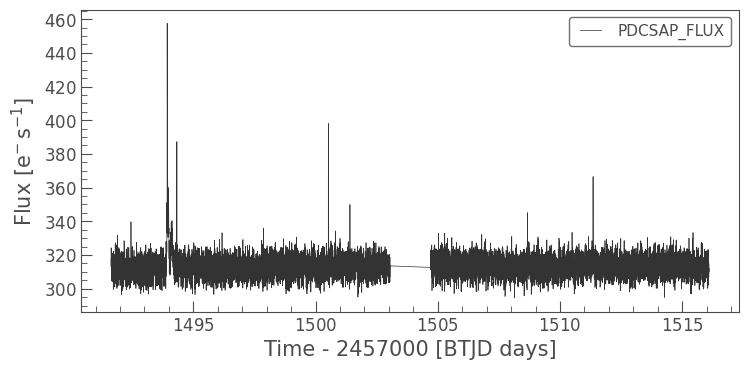

In [47]:
lclc.plot("PDCSAP_FLUX")

#plt.xlim(row.TSTART-.25,row.TSTOP+2.25)
# plt.xlim(1991,1993)
# plt.ylim(790,900)
#row.CAMPAIGN, row.TIC, row.TSTART

In [50]:
lc = lclc.get_lightcurve("PDCSAP_FLUX")
flc = FlareLightCurve(time=lc.time, flux=lc.flux, flux_err=lc.flux_err)

<Quantity 4.23285187 h>

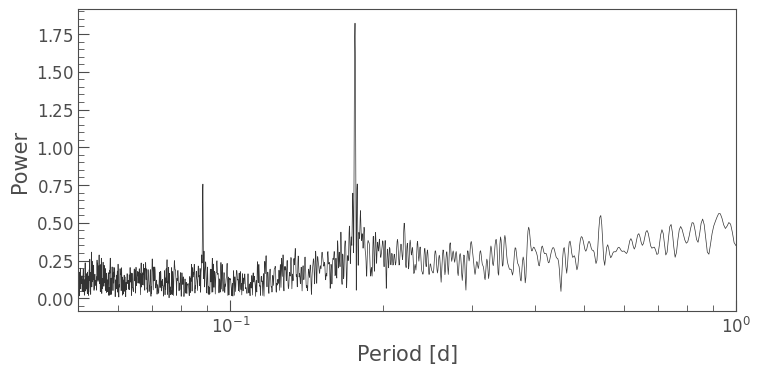

In [51]:
def cosine(x, a, b, c, d):
        return a * np.cos(b * x + c) + d 
    
flck = copy.deepcopy(flc)
pg = flc.remove_nans().to_periodogram(freq_unit=1/u.d,
                                          maximum_frequency=20,
                                          minimum_frequency=1)
pg.plot(view="period")
plt.xlim(0.05,1)
plt.xscale("log")
period = (1 / pg.frequency_at_max_power).to("h")
period

In [40]:
4.56/24

0.18999999999999997

In [ ]:
2 radius

Relative amplitude of modulation: 6.4e-03


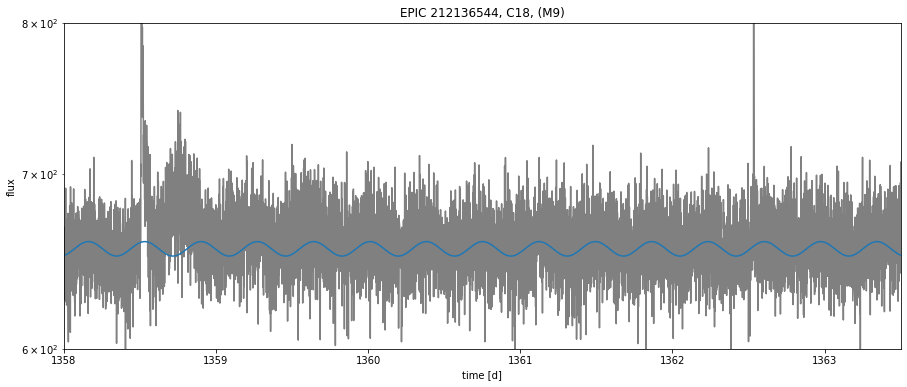

In [341]:
cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux)) 
p, p_cov = optimize.curve_fit(cosine, flck.time[cond], flck.flux[cond],
                                          p0=[np.nanstd(flck.flux),
                                          2*np.pi*pg.frequency_at_max_power.value,
                                          0, np.nanmean(flck.flux)])
#flck.flux = np.nanmean(flck.flux) + flck.flux-cosine(flck.time, p[0], p[1], p[2], p[3])
rel_amplitude = p[0] / np.nanmedian(flck.flux)
print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

plt.figure(figsize=(15,6))
plt.plot(flck.time, flck.flux,c="grey")

#plt.plot(flck.time, np.nanmean(flck.flux) + flck.flux - cosine(flck.time, p[0], p[1], p[2], p[3]))
plt.plot(flck.time, cosine(flck.time, p[0], p[1], p[2], p[3]), label=period)
#plt.xlim(1145, 1155)
plt.title(f"EPIC 212136544, C18, (M9)")
plt.xlabel("time [d]")
plt.ylabel("flux")

plt.ylim(600,800)
plt.xlim(1358,1363.5)
plt.yscale("log")
#plt.savefig("EPIC212136544_c18.png",dpi=300)

In [266]:
flcc, oscis = iteratively_remove_sines(flc)

Found peak in periodogram at  0.5170836371925018 1 / d
SNR at  1.3925308979405424
Found peak in periodogram at  7.58986211696238 1 / d
SNR at  1.6016817316952692


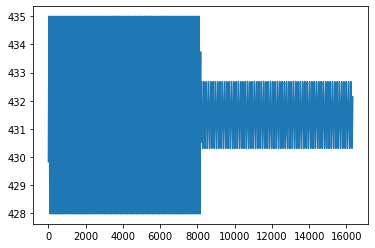

In [253]:


import itertools

OCS = list(itertools.chain.from_iterable(oscis))


plt.plot(OCS)

In [303]:
df = pd.read_csv("/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/stz2205_supplemental_file/Doyle_TESS_star_sample.dat",
                skiprows=7, header=None, delimiter="\s+")

In [304]:
df = df.loc[:,[0,6,7,8,]]
df = df.rename(index=str, columns={0:"TIC",6:"nflares",7:"SpT",8:"Prot_d"})

In [387]:
df[(df.Prot_d < 0.5) & (df.SpT > 4)].sort_values(by="Prot_d")

,TIC,nflares,SpT,Prot_d
95,425937691,10,5.5,0.1003
65,158596311,1,4.1,0.1546
66,201789285,1,6.2,0.1599
23,238813187,3,4.5,0.1757
56,201898222,11,4.3,0.2228
122,299178185,7,5.0,0.3115
77,401838575,8,5.5,0.3137
105,237880881,12,5.1,0.3460
101,234495456,19,4.9,0.3806
78,237883772,5,4.1,0.4231


In [478]:
.346*24

8.303999999999998

In [193]:
from lightkurve import search_lightcurvefile, search_targetpixelfile
tpf = search_targetpixelfile(f"TIC {int(row.TIC)}",sector=int(row.CAMPAIGN))

TPF = tpf.download()

TPF.interact()

In [5]:
3740/100

37.4